## **Assignment - 5: Temporal Processing & RNN**
### ID: eo9232
### Name: Md Reza
### IE7860 - Winter 2022

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/Appliances_Energy_Prediction_Dataset.csv')
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d %H:%M:%S')

## **Exploratory Data Analysis (EDA)**

## **Data Exploration**

In [ ]:
df.head()

Appliances  lights         T1       RH_1         T2       RH_2     T3  \
5           50      40  19.890000  46.026667  19.200000  44.500000  19.79   
11         580      60  20.066667  46.396667  19.426667  44.400000  19.79   
17          70      30  20.856667  53.660000  20.200000  47.056667  20.20   
23         110      40  21.100000  46.596667  20.356667  44.963333  20.29   
29         100      20  21.500000  45.333333  20.700000  44.933333  20.39   

         RH_3         T4       RH_4  ...     T9   RH_9     T_out  Press_mm_hg  \
5   44.933333  18.890000  45.730000  ...  17.00  45.29  6.016667   734.000000   
11  44.826667  19.000000  46.430000  ...  16.89  45.29  5.983333   734.433333   
17  48.447500  18.890000  47.963333  ...  16.89  45.29  6.000000   735.083333   
23  46.633333  19.390000  48.426667  ...  16.89  45.00  6.000000   735.366667   
29  46.060000  19.566667  48.466667  ...  16.89  44.70  5.666667   735.733333   

       RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
5   92.000000   5.333333   43.833333   4.800000  44.919484  44.919484  
11  91.166667   5.833333   40.000000   4.616667   8.827838   8.827838  
17  88.500000   6.000000   40.000000   4.183333  49.595305  49.595305  
23  87.166667   6.000000   40.000000   3.933333   6.277755   6.277755  
29  87.833333   6.000000   40.000000   3.733333  17.017450  17.017450  

[5 rows x 28 columns]

**Plot how the features like Appliances, Lights, & Temperature evolve over time.**

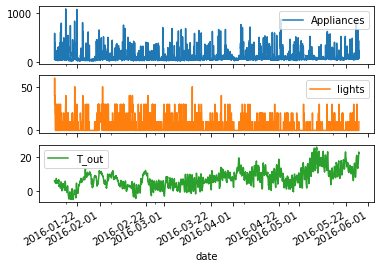

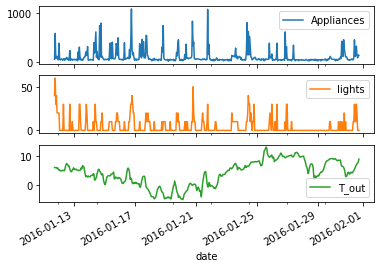

In [ ]:
plot_cols = ['Appliances', 'lights', 'T_out']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

**From the Histogram below, it turns out that Appliances' distributed frequencies are asymmetrical. Therefore, to improve model performance, we will be leveraging the log of Appliances that is more symmetric in distribution.**

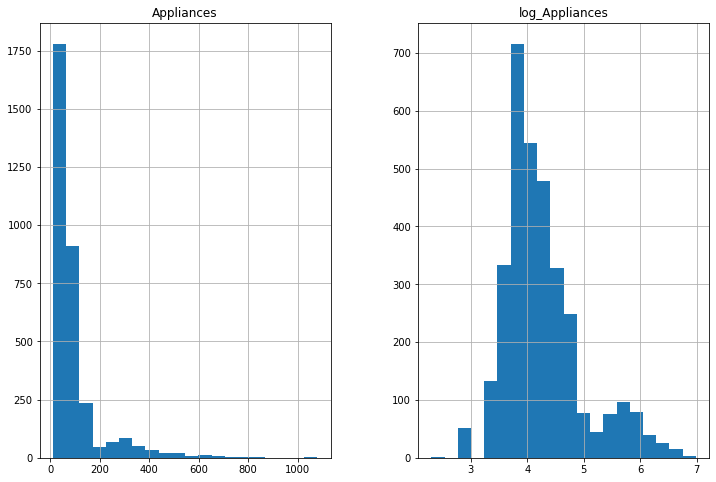

In [ ]:
df['log_Appliances'] = np.log(df.Appliances) 

appliance = ["Appliances","log_Appliances"]
appliance=df[appliance]
appliance.hist(bins = 20, figsize= (12,8)) ;

In [ ]:
df[df.columns[:]].corr()['log_Appliances'][:]

Appliances        0.897386
lights            0.276599
T1                0.166601
RH_1              0.084420
T2                0.216800
RH_2             -0.092931
T3                0.167775
RH_3             -0.009161
T4                0.136117
RH_4             -0.002945
T5                0.117440
RH_5              0.030952
T6                0.196542
RH_6             -0.180074
T7                0.118633
RH_7             -0.093998
T8                0.160448
RH_8             -0.165480
T9                0.096081
RH_9             -0.119194
T_out             0.175385
Press_mm_hg      -0.065785
RH_out           -0.226211
Windspeed         0.086731
Visibility       -0.007869
Tdewpoint         0.055704
rv1              -0.017780
rv2              -0.017780
log_Appliances    1.000000
Name: log_Appliances, dtype: float64

**Ploting correlation matrix to understand the dataset dynamics.**

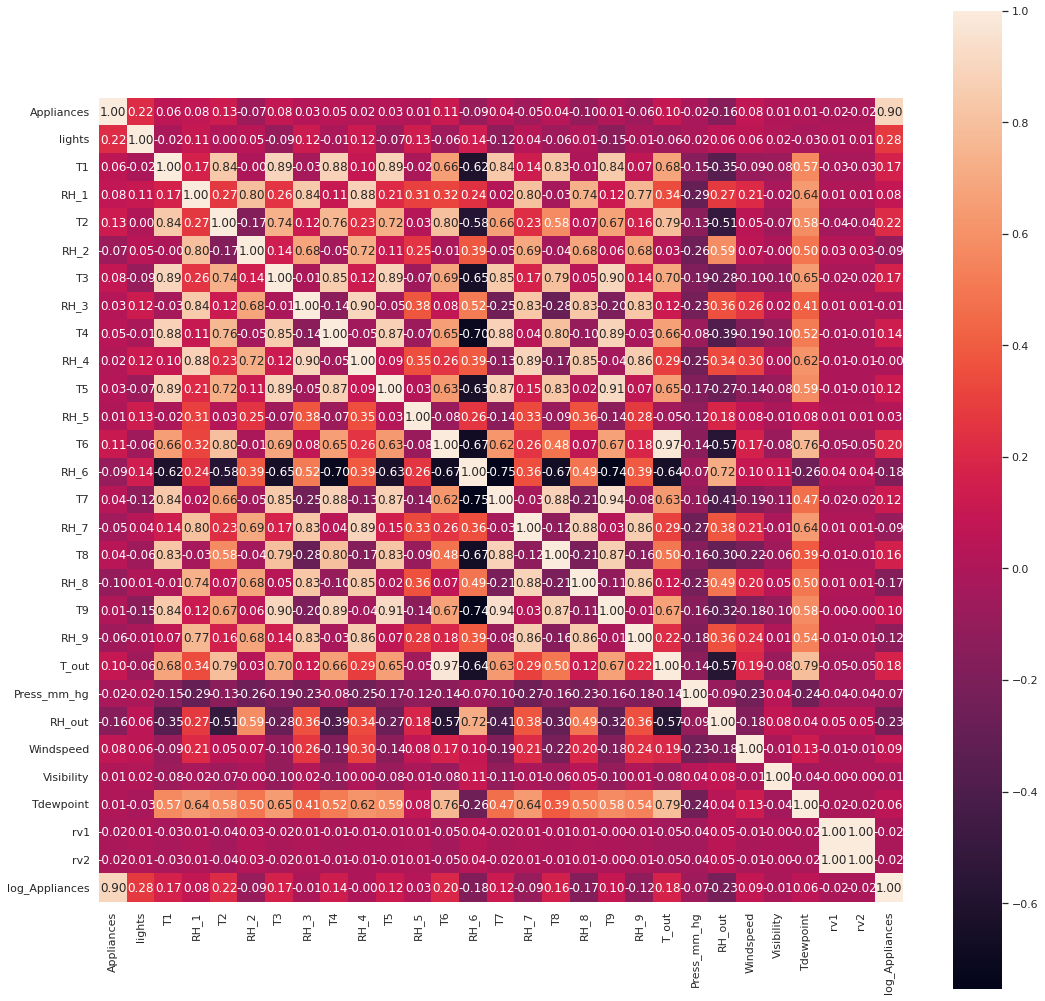

In [ ]:
col = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2', 'log_Appliances']

corr=df.corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();

**Based on the above histogram & correlation plots observations, we could drop ['Appliances'] and continue with ['log_Appliances'] for better prediction and model performance.**

In [ ]:
df = df.drop(columns=['Appliances'])
#round to 3 decimal place
df = df.round(3)

## **Multi Collinearity Check & Features Selections**

In [ ]:
def get_redundant_pairs(data):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = data.columns
    for i in range(0, data.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

**Top Absolute Correlations**

In [ ]:
def get_top_abs_correlations(data, n=5):
    au_corr = data.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(data)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print(get_top_abs_correlations(df, 40))

rv1   rv2      1.000000
T6    T_out    0.974807
T7    T9       0.944065
T5    T9       0.911254
T3    T9       0.900491
RH_3  RH_4     0.899274
RH_4  RH_7     0.894447
T1    T3       0.892565
T4    T9       0.888548
T3    T5       0.888084
T1    T5       0.885336
RH_7  RH_8     0.884158
T7    T8       0.882243
RH_1  RH_4     0.881191
T4    T7       0.877680
T1    T4       0.877175
T4    T5       0.872647
T5    T7       0.871302
T8    T9       0.868346
RH_7  RH_9     0.858827
RH_4  RH_9     0.856810
RH_8  RH_9     0.856063
T3    T4       0.852454
RH_4  RH_8     0.847848
T3    T7       0.847258
RH_1  RH_3     0.844666
T1    T9       0.844211
      T7       0.839102
      T2       0.837001
RH_3  RH_9     0.834505
      RH_7     0.833684
      RH_8     0.830587
T1    T8       0.825579
T5    T8       0.825253
RH_1  RH_7     0.803320
T2    T6       0.801117
RH_1  RH_2     0.797777
T4    T8       0.796463
T3    T8       0.794956
T2    T_out    0.792336
dtype: float64


In [ ]:
corr_matrix_transformed = df.corr()
corr_matrix_transformed

lights        T1      RH_1        T2      RH_2        T3  \
lights          1.000000 -0.018710  0.106194  0.000743  0.046946 -0.091632   
T1             -0.018710  1.000000  0.165910  0.837001 -0.002183  0.892565   
RH_1            0.106194  0.165910  1.000000  0.271116  0.797777  0.256036   
T2              0.000743  0.837001  0.271116  1.000000 -0.165795  0.735413   
RH_2            0.046946 -0.002183  0.797777 -0.165795  1.000000  0.138082   
T3             -0.091632  0.892565  0.256036  0.735413  0.138082  1.000000   
RH_3            0.123109 -0.028857  0.844666  0.120698  0.678784 -0.011670   
T4             -0.008115  0.877175  0.107839  0.762011 -0.047630  0.852454   
RH_4            0.116710  0.098313  0.881191  0.231396  0.722328  0.123077   
T5             -0.073809  0.885336  0.206787  0.720138  0.110772  0.888084   
RH_5            0.133953 -0.017844  0.306819  0.027191  0.253452 -0.067540   
T6             -0.064198  0.655449  0.318705  0.801117 -0.009428  0.687412   
RH_6            0.143356 -0.615601  0.243700 -0.580641  0.389983 -0.648087   
T7             -0.121856  0.839102  0.022627  0.664072 -0.051411  0.847258   
RH_7            0.036772  0.136326  0.803320  0.230364  0.691940  0.173598   
T8             -0.062650  0.825579 -0.028406  0.578358 -0.041100  0.794956   
RH_8            0.008768 -0.005441  0.739288  0.069426  0.681694  0.045232   
T9             -0.146913  0.844211  0.117432  0.674552  0.055387  0.900491   
RH_9           -0.012456  0.073040  0.765865  0.158445  0.678181  0.135745   
T_out          -0.060836  0.682951  0.342336  0.792336  0.032884  0.699450   
Press_mm_hg    -0.018631 -0.151812 -0.293439 -0.133338 -0.255985 -0.190625   
RH_out          0.059307 -0.345214  0.273748 -0.505191  0.585936 -0.281511   
Windspeed       0.064344 -0.087322  0.206736  0.053109  0.067580 -0.100014   
Visibility      0.016841 -0.075332 -0.021219 -0.068805 -0.004944 -0.100808   
Tdewpoint      -0.027111  0.571500  0.640986  0.582517  0.499413  0.645941   
rv1             0.005690 -0.025388  0.006368 -0.040918  0.033212 -0.019056   
rv2             0.005690 -0.025388  0.006368 -0.040918  0.033212 -0.019056   
log_Appliances  0.276599  0.166549  0.084427  0.216772 -0.092937  0.167722   

                    RH_3        T4      RH_4        T5  ...      RH_9  \
lights          0.123109 -0.008115  0.116710 -0.073809  ... -0.012456   
T1             -0.028857  0.877175  0.098313  0.885336  ...  0.073040   
RH_1            0.844666  0.107839  0.881191  0.206787  ...  0.765865   
T2              0.120698  0.762011  0.231396  0.720138  ...  0.158445   
RH_2            0.678784 -0.047630  0.722328  0.110772  ...  0.678181   
T3             -0.011670  0.852454  0.123077  0.888084  ...  0.135745   
RH_3            1.000000 -0.141050  0.899274 -0.051059  ...  0.834505   
T4             -0.141050  1.000000 -0.048998  0.872647  ... -0.025489   
RH_4            0.899274 -0.048998  1.000000  0.091530  ...  0.856810   
T5             -0.051059  0.872647  0.091530  1.000000  ...  0.073753   
RH_5            0.378060 -0.074221  0.352429  0.031070  ...  0.277005   
T6              0.075945  0.652208  0.259177  0.630112  ...  0.184767   
RH_6            0.515255 -0.703396  0.391499 -0.633233  ...  0.390905   
T7             -0.251037  0.877680 -0.131153  0.871302  ... -0.077211   
RH_7            0.833684  0.043970  0.894447  0.150058  ...  0.858827   
T8             -0.283814  0.796463 -0.167111  0.825253  ... -0.155926   
RH_8            0.830587 -0.095061  0.847848  0.017730  ...  0.856063   
T9             -0.195983  0.888548 -0.044582  0.911254  ... -0.008938   
RH_9            0.834505 -0.025489  0.856810  0.073753  ...  1.000000   
T_out           0.117177  0.663094  0.293069  0.651962  ...  0.223647   
Press_mm_hg    -0.233007 -0.075661 -0.250179 -0.171984  ... -0.183402   
RH_out          0.356903 -0.388225  0.336119 -0.274279  ...  0.358474   
Windspeed       0.262451 -0.185120  0.299009 -0.143830  ...  0.238234   
Vis

In [ ]:
corr_matrix_transformed = corr_matrix_transformed[['log_Appliances']].copy()
corr_matrix_transformed.drop(index='log_Appliances', inplace=True)
corr_matrix_transformed.sort_values('log_Appliances', inplace=True)

**Remove those features with less than 10% (0.1) correlations with the target variable.**

In [ ]:
features_to_keep = corr_matrix_transformed.loc[~corr_matrix_transformed['log_Appliances'].between(-0.099, 0.0999)]

In [ ]:
features_to_keep = features_to_keep.index.tolist()
features_to_keep

['RH_out',
 'RH_6',
 'RH_8',
 'RH_9',
 'T5',
 'T7',
 'T4',
 'T8',
 'T1',
 'T3',
 'T_out',
 'T6',
 'T2',
 'lights']

In [ ]:
df = df[features_to_keep + ['log_Appliances']]

**Pairs plot with selected features have more than 10% correlation to understand the dynamics.**

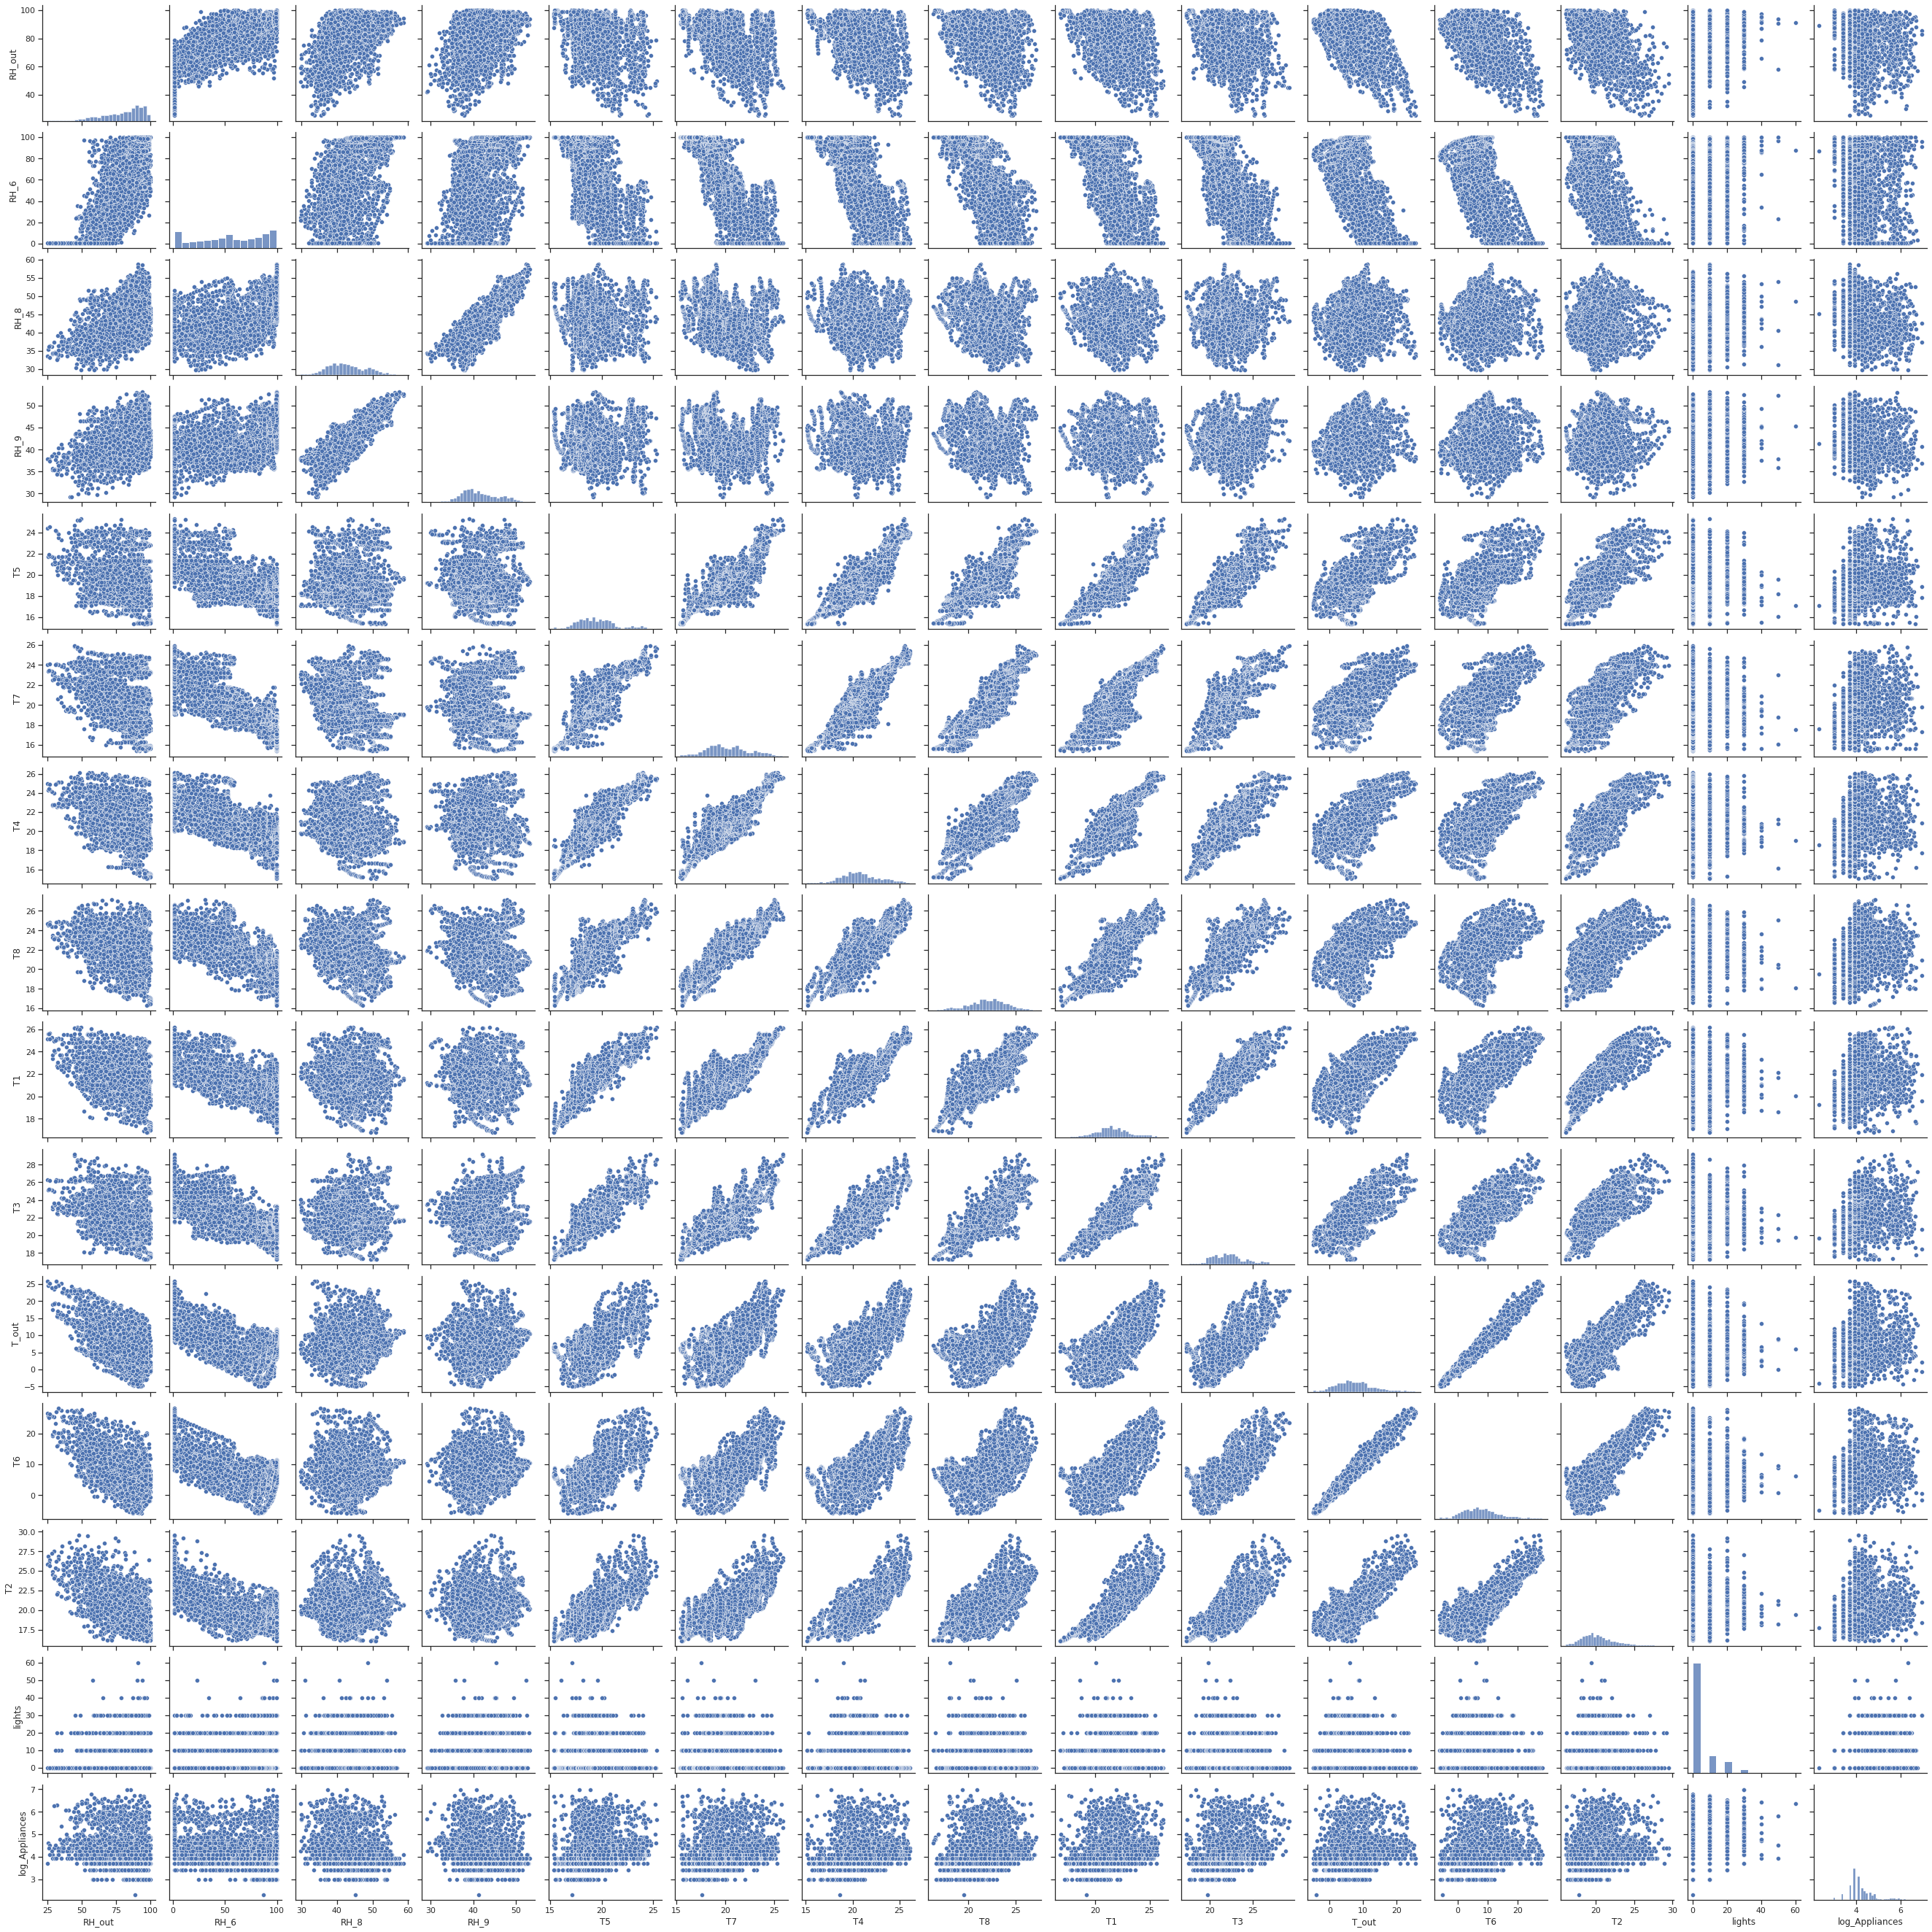

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df)
plt.show();

## **Data Inspection & Cleaning**

**Next look at the statistics of the dataset:**

In [ ]:
df.describe().transpose()

count       mean        std     min     25%     50%     75%  \
RH_out          3289.0  79.747137  14.925525  25.167  70.333  83.833  91.500   
RH_6            3289.0  54.633335  31.140110   1.000  29.927  55.297  83.193   
RH_8            3289.0  42.935281   5.224187  29.823  39.090  42.400  46.577   
RH_9            3289.0  41.552379   4.151584  29.230  38.500  40.900  44.290   
T5              3289.0  19.592459   1.846377  15.345  18.275  19.390  20.600   
T7              3289.0  20.268189   2.110459  15.390  18.700  20.040  21.600   
T4              3289.0  20.855879   2.042772  15.100  19.500  20.633  22.100   
T8              3289.0  22.029264   1.956512  16.307  20.790  22.100  23.390   
T1              3289.0  21.687701   1.605605  16.790  20.760  21.600  22.600   
T3              3289.0  22.268169   2.005932  17.260  20.790  22.100  23.323   
T_out           3289.0   7.412886   5.321700  -4.989   3.683   6.933  10.433   
T6              3289.0   7.914235   6.091784  -6.000   3.592   7.300  11.263   
T2              3289.0  20.341586   2.193966  16.100  18.790  20.000  21.500   
lights          3289.0   3.821830   7.897218   0.000   0.000   0.000   0.000   
log_Appliances  3289.0   4.309700   0.666015   2.303   3.912   4.094   4.605   

                    max  
RH_out          100.000  
RH_6             99.900  
RH_8             58.672  
RH_9             53.223  
T5               25.323  
T7               25.927  
T4               26.100  
T8               27.133  
T1               26.200  
T3               29.199  
T_out            25.817  
T6               28.236  
T2               29.533  
lights           60.000  
log_Appliances    6.985

**Convert Time to Seconds** 

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

**Leverage `sin` and `cos` to convert the time to "Time of the day" and "Time of year" signals, which would give the model access to the most important frequency features.**

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

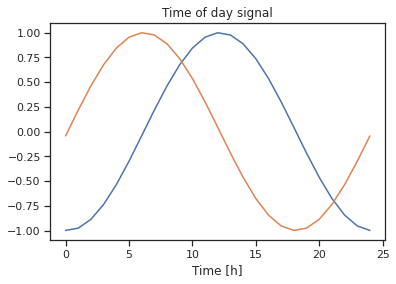

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

**Check the above assumptions with tf.signal.rfft of the log_Appliances over time.**

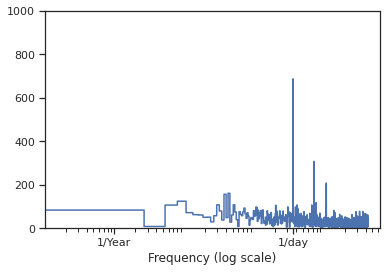

In [ ]:
fft = tf.signal.rfft(df['log_Appliances'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['log_Appliances'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## **Train, Validation, & Test Splits**

**(70%, 20%, 10%) split for the training, validation, and test sets.**

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3289 entries, 5 to 19733
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RH_out          3289 non-null   float64
 1   RH_6            3289 non-null   float64
 2   RH_8            3289 non-null   float64
 3   RH_9            3289 non-null   float64
 4   T5              3289 non-null   float64
 5   T7              3289 non-null   float64
 6   T4              3289 non-null   float64
 7   T8              3289 non-null   float64
 8   T1              3289 non-null   float64
 9   T3              3289 non-null   float64
 10  T_out           3289 non-null   float64
 11  T6              3289 non-null   float64
 12  T2              3289 non-null   float64
 13  lights          3289 non-null   int64  
 14  log_Appliances  3289 non-null   float64
 15  Day sin         3289 non-null   float64
 16  Day cos         3289 non-null   float64
 17  Year sin        3289 non-null   

## **Normalized/Scaled The Data**

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

**Now check the distribution of the features in the violin plot below. Though some features have long tails, there are no apparent errors with unexpected values.**

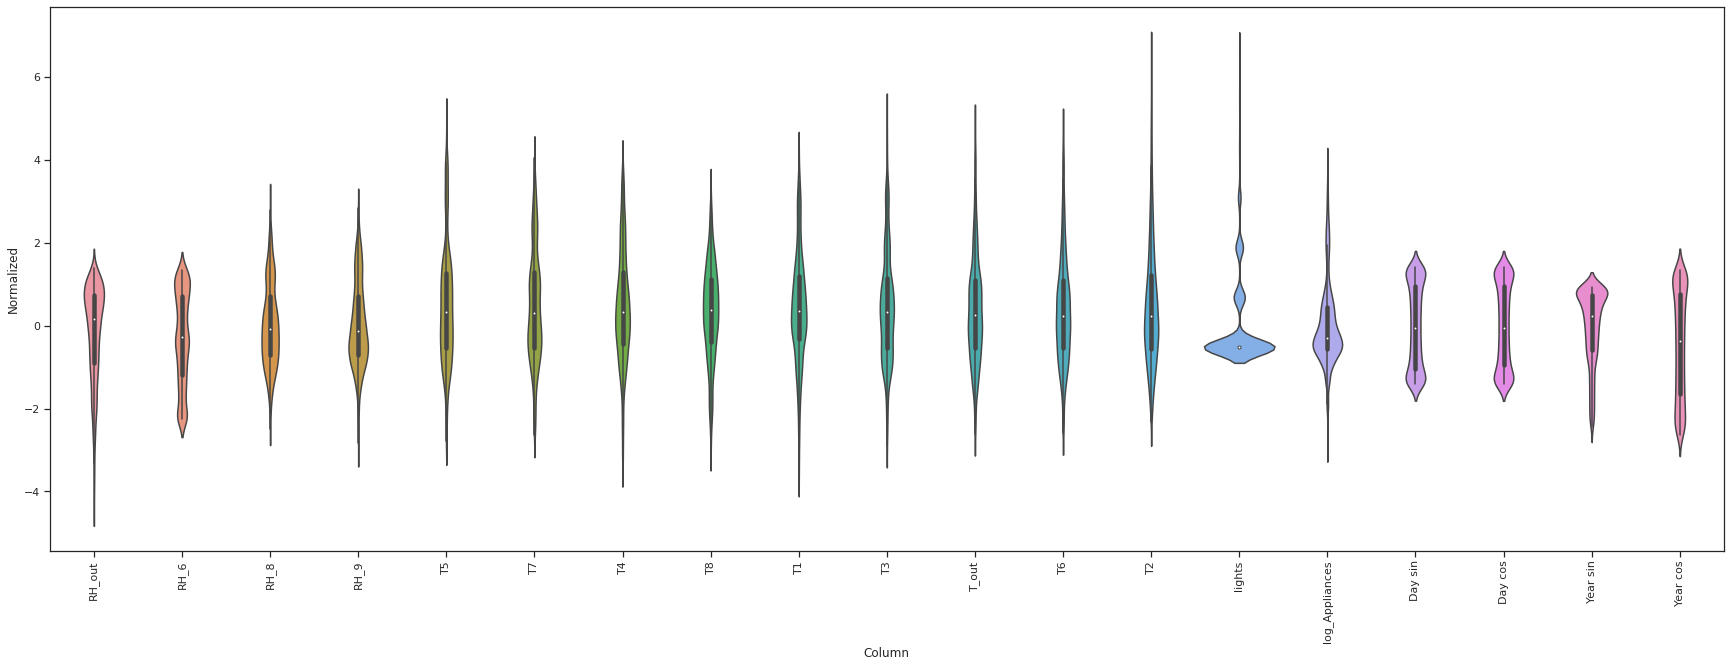

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(30, 10))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## **Data Windowing**


### **1. Indexes and offsets**

**Start by creating the `WindowGenerator` class. These will be converted to `tf.data.Dataset formatted `s windows later.**

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

**Create The Window** 

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['log_Appliances'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['log_Appliances']

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['log_Appliances'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['log_Appliances']

**2. Split the window into inputs and labels.**

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

**Test the Window**

In [ ]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


**3. Methods for Plotting the Split Window**

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='log_Appliances', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

**Plot the aligned inputs labels with splitted window**

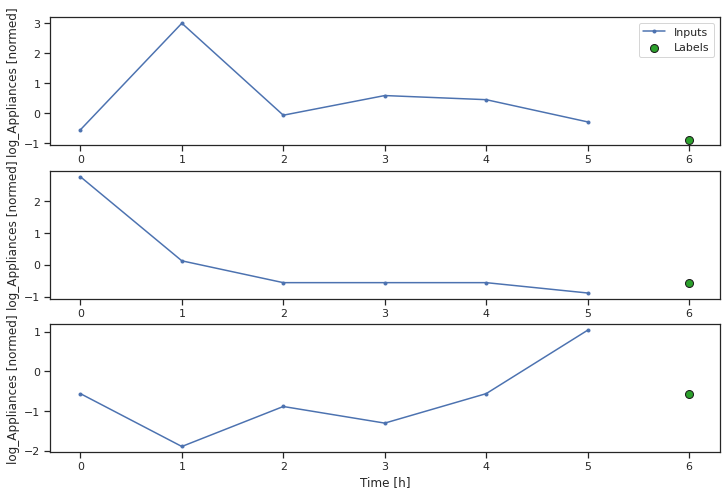

In [ ]:
w2.plot()

**Plot the T_out (Outside Tempature)**

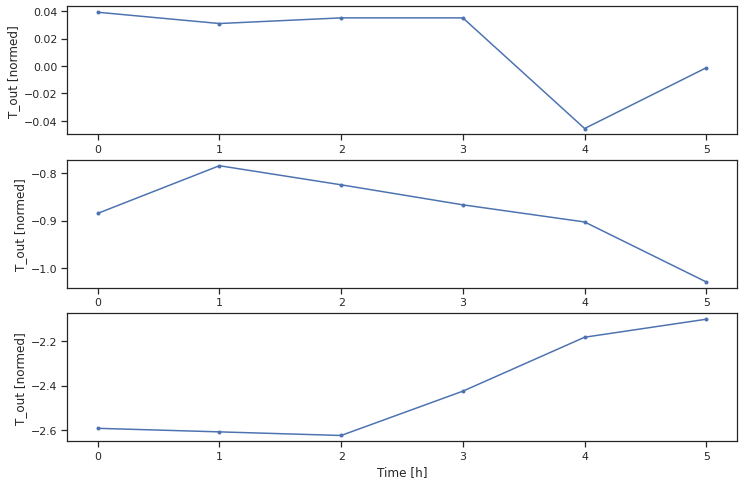

In [ ]:
# Split Window with T_out
w2.plot(plot_col='T_out')

**4. Create `tf.data.Dataset`s**

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.0


**Add properties to access WindowGenerator object as `tf.data.Datasets` using `make_dataset` method.**

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

**Now the `WindowGenerator` object gives access to the `tf.data.Dataset` objects to iterate over the data.**

In [ ]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

**Iterating over the `Dataset` yields concrete batches:**

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## **Single Step Models with Selected Features**
For the single-step model, the training data consists of hourly samples. However, here, the models will learn to predict 1 hour of the future, given 24h of the past.

**Define some required functions for window generation and model compilation.**

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['log_Appliances'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['log_Appliances']

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


### **Baseline Model**



In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

10/10 [==============================] - 1s 3ms/step - loss: 0.1065 - mean_absolute_error: 0.1670


**Visualize Performance Metrics:**
Plot the baseline model's predictions, and it turns out that simply the labels shifted right by one hour.

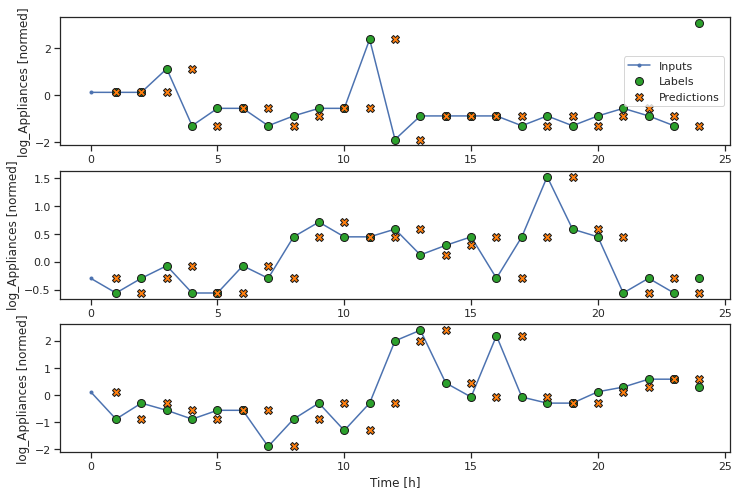

In [ ]:
wide_window.plot(baseline)

### **LSTM**

In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

10/10 [==============================] - 0s 5ms/step - loss: 0.3160 - mean_absolute_error: 0.4036

CPU times: user 29.9 s, sys: 4.6 s, total: 34.5 s
Wall time: 30.6 s


**Visualize Performance Metrics**

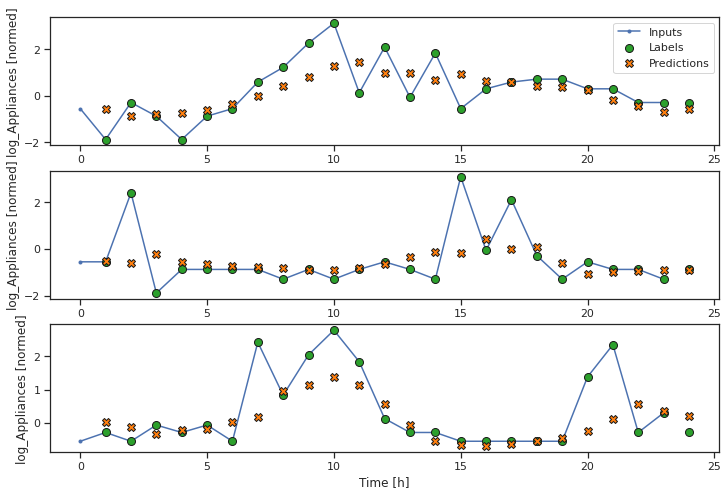

In [ ]:
wide_window.plot(lstm_model)

### **GRU**

In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

GRU_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(GRU_model, wide_window)

IPython.display.clear_output()
val_performance['GRU'] = GRU_model.evaluate( wide_window.val)
performance['GRU'] = GRU_model.evaluate( wide_window.test, verbose=0)

print()

10/10 [==============================] - 0s 5ms/step - loss: 0.2010 - mean_absolute_error: 0.3238

CPU times: user 28.7 s, sys: 4.37 s, total: 33 s
Wall time: 29.4 s


**Visualize Performance Metrics.**

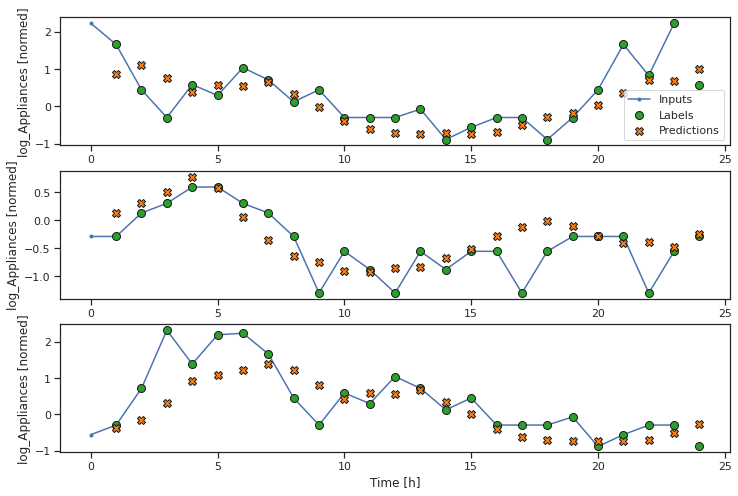

In [ ]:
wide_window.plot(GRU_model)

### **RNN**

In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

RNN_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(RNN_model, wide_window)

IPython.display.clear_output()
val_performance['RNN'] = RNN_model.evaluate( wide_window.val)
performance['RNN'] = RNN_model.evaluate( wide_window.test, verbose=0)

print()

10/10 [==============================] - 0s 7ms/step - loss: 0.2693 - mean_absolute_error: 0.3673

CPU times: user 1min 18s, sys: 11.9 s, total: 1min 30s
Wall time: 1min 20s


**Visualize Performance Metrics.**

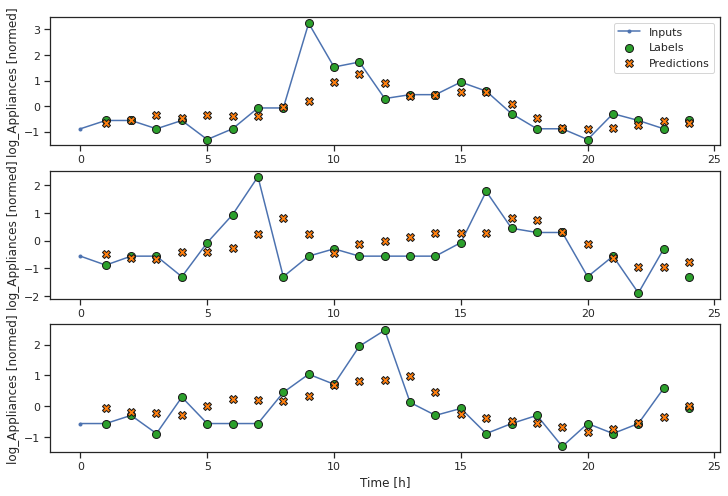

In [ ]:
wide_window.plot(RNN_model)

### **Advanced: Residual Connections**



In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

10/10 [==============================] - 0s 5ms/step - loss: 0.0821 - mean_absolute_error: 0.1490

CPU times: user 10.1 s, sys: 1.17 s, total: 11.2 s
Wall time: 10.7 s


**Visualize Performance Metrics.**

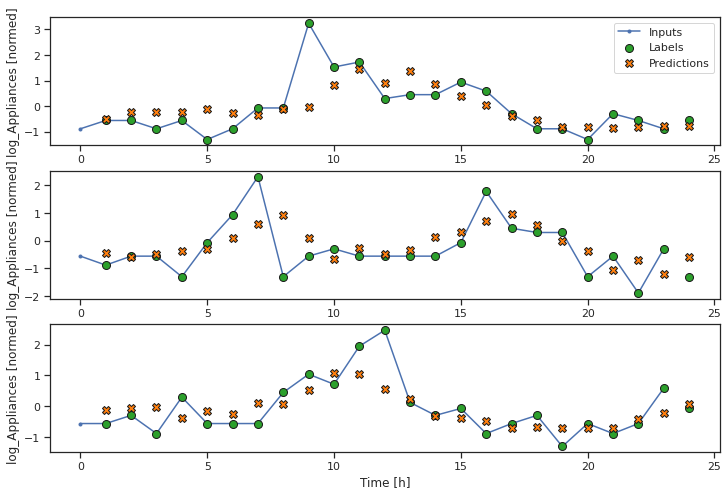

In [ ]:
wide_window.plot(residual_lstm)

In the above plots of three examples, the single-step model runs over 24 hours to predict one hour in the future. Where:
- The blue Inputs line shows the input value at each time step.
- The green Labels dots show the target prediction value. 
- The orange Predictions crosses are the model's prediction's for each output time step. 

## **Single Step Models' Performance Compared:**

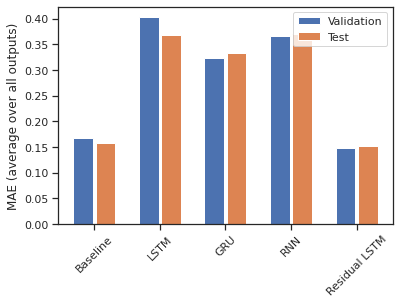

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1587
LSTM           : 0.3678
GRU            : 0.3333
RNN            : 0.3700
Residual LSTM  : 0.1511


## **Multi-Step Models with Selected Features**
For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

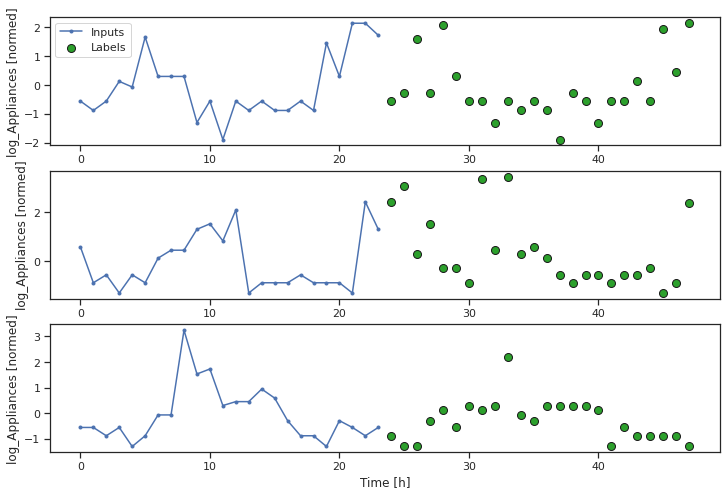

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### **Baseline Model**

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Baseline Multi Step Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Baseline Multi Step Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

9/9 [==============================] - 0s 3ms/step - loss: 1.1036 - mean_absolute_error: 0.6741


**Visualize Performance Metrics.**

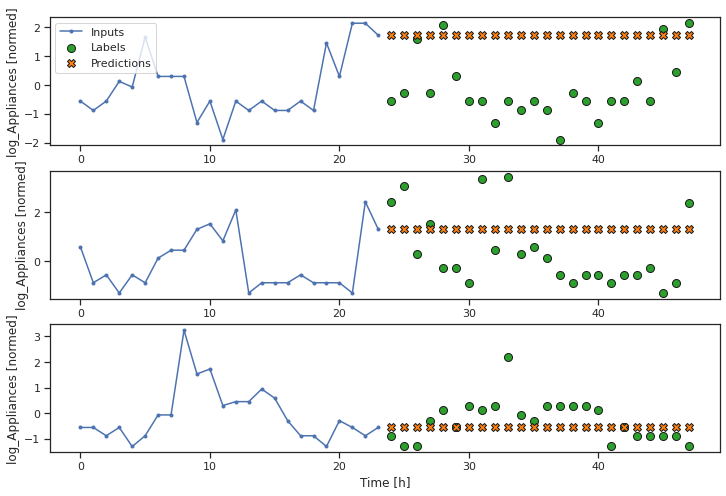

In [ ]:
multi_window.plot(last_baseline)

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Baseline Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Baseline Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

9/9 [==============================] - 0s 3ms/step - loss: 0.3488 - mean_absolute_error: 0.3733


**Visualize Performance Metrics.**

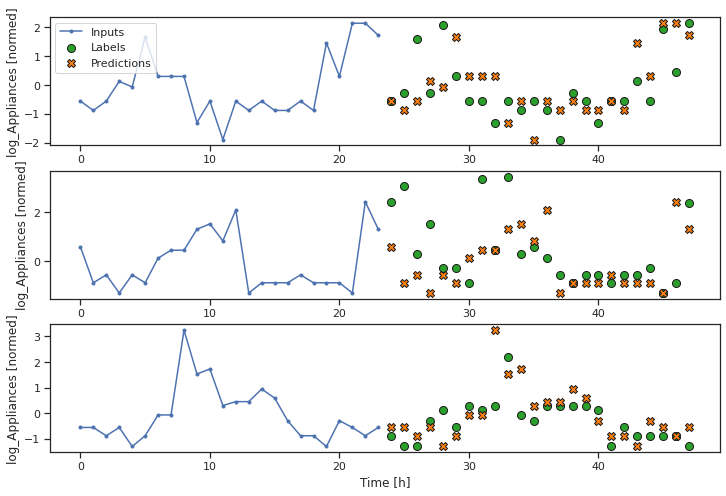

In [ ]:
multi_window.plot(repeat_baseline)

### **LSTM**

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

9/9 [==============================] - 0s 4ms/step - loss: 1.5392 - mean_absolute_error: 0.9342


**Visualize Performance Metrics.**

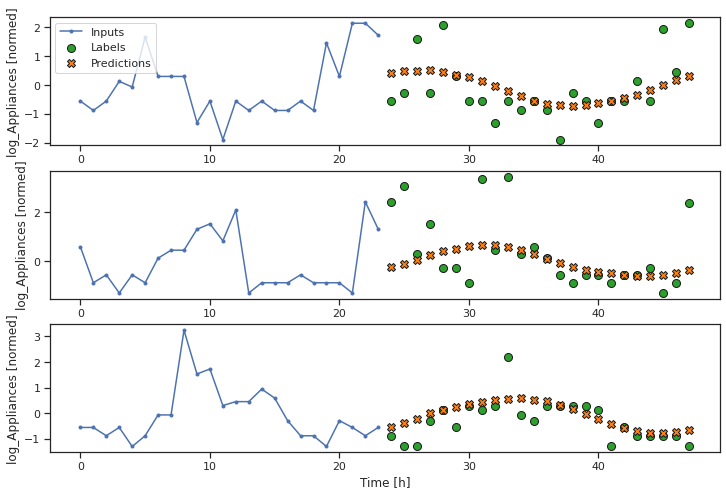

In [ ]:
multi_window.plot(multi_lstm_model)

### **GRU**

In [ ]:
multi_GRU_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_GRU_model, multi_window)

IPython.display.clear_output()

multi_val_performance['GRU'] = multi_GRU_model.evaluate(multi_window.val)
multi_performance['GRU'] = multi_GRU_model.evaluate(multi_window.test, verbose=0)

9/9 [==============================] - 0s 4ms/step - loss: 1.1748 - mean_absolute_error: 0.8178


**Visualize Performance Metrics.**

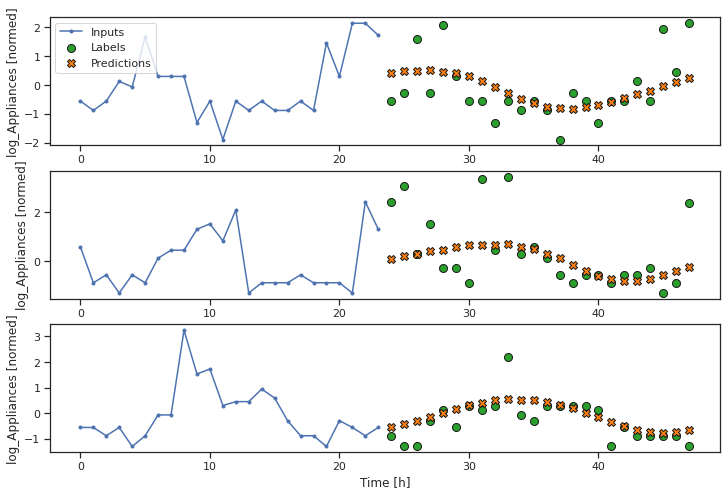

In [ ]:
multi_window.plot(multi_GRU_model)

### **RNN**

In [ ]:
multi_RNN_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.SimpleRNN(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_RNN_model, multi_window)

IPython.display.clear_output()

multi_val_performance['RNN'] = multi_RNN_model.evaluate(multi_window.val)
multi_performance['RNN'] = multi_RNN_model.evaluate(multi_window.test, verbose=0)

9/9 [==============================] - 0s 6ms/step - loss: 1.1605 - mean_absolute_error: 0.8019


**Visualize Performance Metrics.**

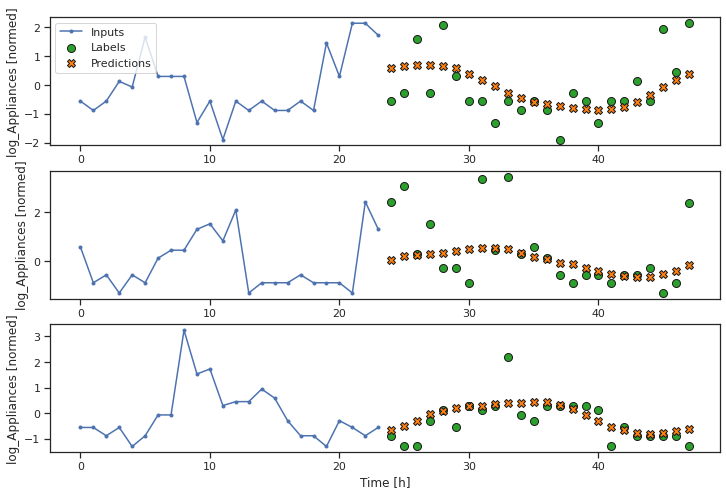

In [ ]:
multi_window.plot(multi_RNN_model)

In the above plots of three examples, the single-step model runs over 24 hours to predict 24 hours in the future. Where:
- The blue Inputs line shows the input value at each time step.
- The green Labels dots show the target prediction value. 
- The orange Predictions crosses are the model's prediction's for each output time step. 

## **Autoregressive Model**
An autoregression time series model that uses observations from previous time steps as input to predicts the value at the next step with a regression equation. 


### **Autoregressive RNN model**

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

**This method returns a single time-step prediction, and the internal state of the LSTM:**

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

**For a dynamic output length leverage a `tf.TensorArray` and `tf.range` instead of the python `list` and `range`.**

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


### **Model Compilation**

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

9/9 [==============================] - 0s 13ms/step - loss: 1.4064 - mean_absolute_error: 0.9111


**Visualize Performance Metrics.**

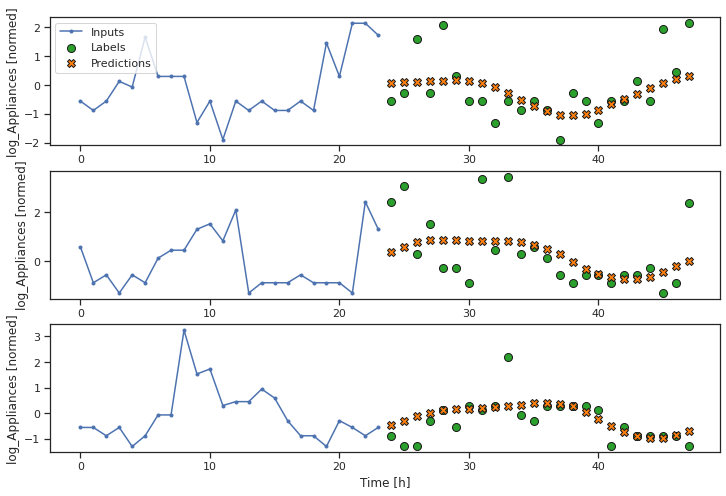

In [ ]:
multi_window.plot(feedback_model)

In the above plots of three examples, the single-step model runs over 24 hours to predict 24 hours in the future. Where:
- The blue Inputs line shows the input value at each time step.
- The green Labels dots show the target prediction value. 
- The orange Predictions crosses are the model's prediction's for each output time step. 

## **Multi-Steps Models' Performance Compared:**

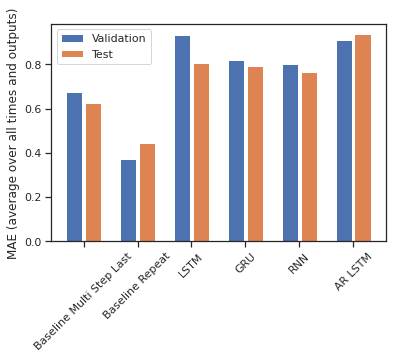

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Baseline Multi Step Last: 0.6249
Baseline Repeat: 0.4439
LSTM    : 0.8049
GRU     : 0.7937
RNN     : 0.7659
AR LSTM : 0.9361
